In [6]:
import torch
import torch.nn as nn
import tiktoken
from torch.nn import functional as F
from modules import GPTModel, TransformerBlock ,LayerNorm ,GELU ,FeedForward , MultiHeadAttention
import modules
import importlib
importlib.reload(modules)

from modules import GPTDatasetV1 , create_dataloader_v1 ,generate_next_token

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

In [8]:
def text_to_token_ids(text , tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) ## add the batch dimension 
    return encoded_tensor


def ids_token_to_text(ids , tokenizer) : 
    flat = ids.squeeze(0) ## remove batch dimension
    decoded = tokenizer.decode(flat.tolist())
    return decoded
    

In [9]:
text = "Every effort moves you "
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_next_token(
    model=model,
    idx = text_to_token_ids(text,tokenizer) , 
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)
print(f"Model Output : {ids_token_to_text(token_ids,tokenizer)}")

Model Output : Every effort moves you  Stores CommanderTra Warm stereotypes eventual


In [10]:
text1 = "every effort moves"
text2 = "I really like"

target1 = "effort moves you forward"
target2 = "really like chocolate"

In [11]:
inputs = torch.tensor([[16833, 3626, 6100],[40, 1107, 588]])
targets = torch.tensor([[3626, 6100, 345 ], [1107, 588, 11311]])

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

device : cpu


In [13]:
with torch.no_grad():
    logits = model(inputs.to(device))
print(logits)
probs = F.softmax(logits , dim=-1) ## probability of each token in the vocabulary
print(probs)
print(f"probs.shape : {probs.shape}")

tensor([[[ 0.1113, -0.1057, -0.3666,  ...,  0.2843, -0.8824,  0.1074],
         [-0.6109, -0.5167, -0.7613,  ...,  0.5450, -1.0319, -0.2175],
         [ 0.5707, -0.6459, -0.0701,  ...,  0.7419, -0.1806, -0.2217]],

        [[-0.2968,  0.1949, -0.1649,  ..., -0.4867,  0.7218, -0.1714],
         [-0.8375,  0.0612, -0.4641,  ...,  0.2327, -0.3889, -0.0770],
         [ 0.5614,  0.6919,  0.8915,  ..., -0.9472,  1.2411, -0.2056]]])
tensor([[[1.8849e-05, 1.5172e-05, 1.1687e-05,  ..., 2.2409e-05,
          6.9776e-06, 1.8776e-05],
         [9.1569e-06, 1.0062e-05, 7.8786e-06,  ..., 2.9090e-05,
          6.0103e-06, 1.3571e-05],
         [2.9877e-05, 8.8507e-06, 1.5741e-05,  ..., 3.5456e-05,
          1.4094e-05, 1.3526e-05]],

        [[1.2561e-05, 2.0537e-05, 1.4332e-05,  ..., 1.0389e-05,
          3.4784e-05, 1.4239e-05],
         [7.2731e-06, 1.7864e-05, 1.0565e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5559e-05],
         [2.9496e-05, 3.3605e-05, 4.1029e-05,  ..., 6.5249e-06,
         

In [14]:
token_ids = torch.argmax(probs,dim=-1,keepdim=True)
print(token_ids)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [15]:
print(f"targets batch 1 : {ids_token_to_text(targets[0],tokenizer)}")
print(f"outputs batch 1 : {ids_token_to_text(token_ids[0].flatten(),tokenizer)}")
## ==> the model will produce random text because it is not trained yet

targets batch 1 :  effort moves you
outputs batch 1 :  Armed heNetflix


In [16]:
target_probs_1 = probs[0,[0,1,2],targets[0]]
print(target_probs_1)
target_probs_2 = probs[1,[0,1,2],targets[1]]
print(target_probs_2)

tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [17]:
log_probs = torch.log(torch.cat(((target_probs_1,target_probs_2))))
print(log_probs)

avg_log = torch.mean(log_probs)
print(f"Average log probs : {avg_log}")

neg_avg = avg_log * -1 
print(f"Average log probs : {neg_avg}")

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
Average log probs : -10.793965339660645
Average log probs : 10.793965339660645


In [18]:
print(f"logits.shape : {logits.shape}")
print(f"targets.shape : {targets.shape}")

logits.shape : torch.Size([2, 3, 50257])
targets.shape : torch.Size([2, 3])


In [19]:
logits_flatten = logits.flatten(0,1)
print(f"logits_flatten.shape : {logits_flatten.shape}")
targets_flatten = targets.flatten(0,1)
print(f"targets_flatten.shape : {targets_flatten.shape}")

logits_flatten.shape : torch.Size([6, 50257])
targets_flatten.shape : torch.Size([6])


In [20]:
loss = F.cross_entropy(logits_flatten , targets_flatten)
print(loss) ## ==> same as the negative avg probability we already calculated 

tensor(10.7940)


In [21]:
file_path = "the-verdict.txt"
with open(file_path,"r",encoding="utf-8") as file : 
    text_data = file.read()

In [22]:
total_chars  = len(text_data)
total_tokens = len(tokenizer.encode(text_data)) 
print(f"characters : " , total_chars)
print(f"Tokens     : ", total_tokens)

characters :  20479
Tokens     :  5145


In [23]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [24]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    txt=train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    txt=val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [25]:
print(f"train loader : \n")
for x,y in train_loader : 
    print(x.shape   , y.shape)

print(f"val loader : \n")
for x,y in val_loader : 
    print(x.shape   , y.shape)

train loader : 

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
val loader : 

torch.Size([2, 256]) torch.Size([2, 256])


In [ ]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch  = input_batch.to(device) 
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = F.cross_entropy(logits.flatten(0,1) , target_batch.flatten())
    return loss

In [27]:
loss = calc_loss_batch(inputs,targets,model,logits_flatten.device)
print(f"loss : {loss}")

loss : 10.793964385986328


In [ ]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0.0
    if len(data_loader) == 0 : 
        return float("nan")
    elif num_batches is None : 
        num_batches = len(data_loader) ## if no batch size is given , we iterate over all batches 
    else : 
        num_batches = min(num_batches , len(data_loader))
    
    for i ,(input_batch , target_batch) in enumerate(data_loader) : 
        if i<num_batches : 
            loss = calc_loss_batch(input_batch , target_batch , model , device)
            total_loss += loss.item() ##    sums loss for each batch
        else : 
            break
    return total_loss / num_batches ## average loss over all batches 

In [ ]:
model.to(device)

In [30]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss   = calc_loss_loader(val_loader,model,device)
    
print(f"training loss    : {train_loss}")
print(f"validdation loss : {val_loss}")

training loss    : 10.987583584255642
validdation loss : 10.98110580444336


In [31]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
    model.train()
    return train_loss , val_loss

In [32]:
def generate_print_sample(model,tokenizer,device,start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context,tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_next_token(model,idx=encoded,max_new_tokens=50,context_size=context_size)
        decoded = ids_token_to_text(token_ids,tokenizer)
        print(decoded.replace("\n" , " "))
    model.train()    
    

In [33]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,
                       num_epochs,eval_freq,eval_iter,start_context,tokenizer) : 
    train_losses , val_losses ,track_tokens_seen = [],[],[]
    tokens_seen ,global_step = 0,-1
    for epoch in range(num_epochs):
        model.train()
        for input_batch , target_batch in train_loader : 
            optimizer.zero_grad() ## resets the gradients from the previous batch iteration
            loss = calc_loss_batch(input_batch,target_batch,model,device)
            loss.backward()  ## calculates loss gradients
            optimizer.step() ## updates model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1 
            
            if global_step % eval_freq ==0 : 
                train_loss , val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train Loss {train_loss:.3f}  "
                      f"Val Loss {val_loss:.3f}")
        generate_print_sample(model,tokenizer,device,start_context)
    return train_losses , val_losses , track_tokens_seen
     

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
num_epochs = 10
train_losses , val_losses , track_tokens_seen = train_model_simple(
                                model,train_loader,val_loader,optimizer,device,
                                num_epochs,eval_freq=5,eval_iter=5,
                                start_context="Every Effort moves you",
                                tokenizer=tokenizer
                                )

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
num_epochs = 10
def plot_losses(epochs_seen , tokens_seen,train_losses,val_losses):
    fig ,ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen , train_losses , label="Training Loss")
    ax1.plot(epochs_seen , val_losses ,linestyle="-.", label="Validation Loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen,train_losses,alpha=0)
    #ax1.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0,num_epochs,len(train_losses))
plot_losses(epochs_tensor ,track_tokens_seen,train_losses,val_losses)
    

Text Generation strategies 

In [35]:
model.to("cpu")
model.eval() ## in order to turn off random components like dropout during inference 
print(tokenizer)

token_ids = generate_next_token(
    model=model,
    idx=text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

<Encoding 'gpt2'>


In [36]:
print(f"Output text : \n {ids_token_to_text(token_ids , tokenizer)}")

Output text : 
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren Mortgage TT remember gard ACTIONSussedOND Land Engeleddedemate breaths proxies GalaxyForm


Temperature Scaling

In [37]:
vocab = {
"closer": 0,
"every": 1,
"effort": 2,
"forward": 3,
"inches": 4,
"moves": 5,
"pizza": 6,
"toward": 7,
"you": 8,
}
inv_vocab = {v:k for k,v in vocab.items()}
print(inv_vocab)

{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [38]:
## Assuming the LLM is given "Every effort moves you" as input and generates the next output (based on the vocab fom the previous cell) 
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probs = F.softmax(next_token_logits ,dim=-1)
next_token_id = torch.argmax(probs).item()
print(inv_vocab[next_token_id])

forward


In [39]:
## ===> Probabilistic selection from the softmax output (probabilities)
torch.manual_seed(123)
next_token_id = torch.multinomial(probs,num_samples=1).item()
print(inv_vocab[next_token_id])

toward


In [40]:
def print_sampled_tokens(probs) : 
    torch.manual_seed(123)
    sample = [torch.multinomial(probs,num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i,freq in enumerate(sampled_ids) : 
        print(f"{freq} x {inv_vocab[i]}")
print(print_sampled_tokens(probs))

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you
None


In [41]:
"""
    temperature scaling is used to change the distribution of the tokens : 
    temp > 1 ==> more uniformly distributed token probs
    remp < 1 ==> more peaky (confident) distributed token probs
"""
def softmax_with_temperature(logits , temperature):
    scaled_logits = logits / temperature
    return F.softmax(scaled_logits,dim=0)

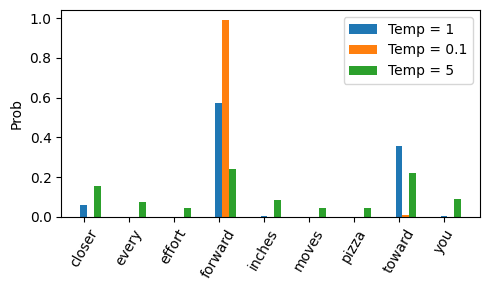

In [43]:
import matplotlib.pyplot as plt 
temp = [1,0.1,5]
scaled_probs = [softmax_with_temperature(next_token_logits,t) for t in temp]
x = torch.arange(len(vocab))
bar_width = 0.15
fig,ax = plt.subplots(figsize=(5,3))
for i,t in enumerate(temp) :
    rects = ax.bar(x+i*bar_width,scaled_probs[i],bar_width,label=f"Temp = {t}")
ax.set_ylabel('Prob')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=60)
ax.legend()
plt.tight_layout()
plt.show()
## as we can see , the higher the temperature is , the more the distribution is uniform ==> more words can be selected by the model
## when training which reduces the probability of the model selecting the same token each time 
## but we should be careful because with very high temperatures the model can select tokens irrelevant to the correct context 
## (every effort move you pizza)  

Top-k Sampling

In [44]:
top_k = 3 
top_logits , top_pos = torch.topk(next_token_logits,top_k)
print(f"top logits : {top_logits}")
print(f"top positions : {top_pos}")

top logits : tensor([6.7500, 6.2800, 4.5100])
top positions : tensor([3, 7, 0])


In [45]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(f"new logits : {new_logits}")

new logits : tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [46]:
topk_probs = F.softmax(new_logits,dim=0)
print(topk_probs)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


Final text generation function (combines probabilistic sampling , temperature scaling and top-k sampling)

In [ ]:
def generate(model,idx,max_new_tokens,context_size,
             temp=0.0,top_k=None,eos_id=None):
    for _ in range(max_new_tokens) : 
        idx_cond = idx[:,-context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:,-1,:]
        if top_k is not None : 
            top_logits , _ = torch.topk(logits,top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                condition=logits < min_val,
                input=torch.tensor(float('-inf')).to(logits.device),
                other=logits
            )
        if temp > 0.0 : 
            logits = logits / temp
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
        else : 
            idx_next = torch.argmax(logits,dim=-1,keepdim=True)
        if idx_next == eos_id : 
            break
        
        idx = torch.cat((idx,idx_next),dim=1) 
    return idx

In [48]:
torch.manual_seed(123)
token_ids = generate(
    model,
    idx=text_to_token_ids("Every effort moves you" , tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=15,
    temp=1.4
    )

print(f"output : {ids_token_to_text(token_ids , tokenizer)}")

output : Every effort moves you Laur similarity Aw137 Bethesda Lara anch republicquel Baton adultigans spotlightConsumer450


In [ ]:
import urllib.request
url = (
"https://raw.githubusercontent.com/rasbt/"
"LLMs-from-scratch/main/ch05/"
"01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x1a0c2744ef0>)

In [125]:
from gpt_download import download_and_load_gpt2 
settings , params = download_and_load_gpt2(
    model_size="124M",models_dir="gpt2"
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [49]:
print(f"Settings : {settings}")
print(f"Parameters dictionary keys : {params.keys()}")

Settings : {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameters dictionary keys : dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [50]:
print(f"token embedding weight tensor shape : {params["wte"].shape}")

token embedding weight tensor shape : (50257, 768)


In [51]:
models_config = {
    "gpt2_small (124M)" : {"emb_dim":768 , "n_layers":12 ,"n_heads":12} , 
    "gpt2_medium (355M)" : {"emb_dim":1024 , "n_layers":24 ,"n_heads":16} , 
    "gpt2_large (774M)" : {"emb_dim":1280 , "n_layers":36,"n_heads":20} , 
    "gpt2_xl (1558M)" : {"emb_dim":1600 , "n_layers":48 ,"n_heads":25} , 
}

In [52]:
model_name = "gpt2_small (124M)"
new_config = GPT_CONFIG_124M.copy()
new_config.update(models_config[model_name])
new_config.update({"context_length":1024})
new_config.update({"qkv_bias":True})
print(new_config)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [ ]:
gpt = GPTModel(new_config)
gpt.eval()

In [ ]:
def assign(left,right):
    if left.shape != right.shape : 
        raise ValueError(f" Shape mismatch .Left: {left.shape}  Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right)) 

In [ ]:
## Loading the weights into our gpt model
import numpy as np 
def load_weights_into_gpt(gpt , params) : 
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight,params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight,params["wte"])
    
    for b in range(len(params["blocks"])) : 
        ## Attention Q,K,V weights
        q_w,k_w,v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"] , 3 , axis=-1)
        gpt.trf_blocks[b].MHattention.w_q.weight =assign(gpt.trf_blocks[b].MHattention.w_q.weight ,q_w.T)
        gpt.trf_blocks[b].MHattention.w_k.weight =assign(gpt.trf_blocks[b].MHattention.w_k.weight ,k_w.T)
        gpt.trf_blocks[b].MHattention.w_v.weight =assign(gpt.trf_blocks[b].MHattention.w_v.weight ,v_w.T)
        ## Attention Q,K,V bias
        q_b , k_b , v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"],3,axis=-1)
        gpt.trf_blocks[b].MHattention.w_q.bias =assign(gpt.trf_blocks[b].MHattention.w_q.bias ,q_b)
        gpt.trf_blocks[b].MHattention.w_k.bias =assign(gpt.trf_blocks[b].MHattention.w_k.bias ,k_b)
        gpt.trf_blocks[b].MHattention.w_v.bias =assign(gpt.trf_blocks[b].MHattention.w_v.bias ,v_b)
        ## Attention out_proj weights and bias
        gpt.trf_blocks[b].MHattention.out_proj.weight = assign(gpt.trf_blocks[b].MHattention.out_proj.weight,params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].MHattention.out_proj.bias   = assign(gpt.trf_blocks[b].MHattention.out_proj.bias,params["blocks"][b]["attn"]["c_proj"]["b"])
        ## feed forward layer weights and bias  
        gpt.trf_blocks[b].ffn.layers[0].weight = assign(gpt.trf_blocks[b].ffn.layers[0].weight,params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[0].bias   = assign(gpt.trf_blocks[b].ffn.layers[0].bias,params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ffn.layers[2].weight = assign(gpt.trf_blocks[b].ffn.layers[2].weight,params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ffn.layers[2].bias   = assign(gpt.trf_blocks[b].ffn.layers[2].bias,params["blocks"][b]["mlp"]["c_proj"]["b"])
        
        gpt.trf_blocks[b].layer_norm_1.scale = assign(gpt.trf_blocks[b].layer_norm_1.scale,params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].layer_norm_1.shift = assign(gpt.trf_blocks[b].layer_norm_1.shift,params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].layer_norm_2.scale = assign(gpt.trf_blocks[b].layer_norm_2.scale,params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].layer_norm_2.shift = assign(gpt.trf_blocks[b].layer_norm_2.shift,params["blocks"][b]["ln_2"]["b"])
        
        gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
        gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
        
        gpt.out_head.weight  = assign(gpt.out_head.weight,  params["wte"])

In [ ]:
load_weights_into_gpt(gpt,params)
gpt.to(device)

In [123]:
torch.manual_seed(138)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you" , tokenizer).to(device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    temp=2,
    top_k=30,
    )


In [124]:
print(f"Output :\n {ids_token_to_text(token_ids , tokenizer)}")

Output :
 Every effort moves you forward on your path!"

You won "The battle of a battlefield of the battle arena!"! A battle




In [ ]:
train_loss , val_loss = evaluate_model(
    model=gpt,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    eval_iter=5
)
print(f"Training and validation set losses of the GPTModel with the pretrained"
      f"weights from OpenAI on the “The Verdict” dataset: \ntraining loss = {train_loss:.3f} -- validation loss = {val_loss:.3f}")

Training and validation set losses of the GPTModel with the pretrainedweights from OpenAI on the “The Verdict” dataset: 
training loss = 3.639 -- validation loss = 3.560
